<a href="https://colab.research.google.com/github/sergekamanzi/Formative2-Data-Preprocessing/blob/main/Formative_2_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1: Data Augmentation on CSV Files**

In [34]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [35]:
# Loading the dataset
data1 = pd.read_csv('/content/customer_transactions.csv', low_memory=False)
data1.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [36]:
data1.shape

(150, 6)

In [37]:
# Cleaning column names
data1.columns = data1.columns.str.strip()

In [38]:
# Renames purchase_amount to TransactionAmount for better readability
column_mapping = {
    'purchase_amount': 'TransactionAmount'
}
data1.rename(columns=column_mapping, inplace=True)

In [39]:
# Ensuring 'TransactionAmount' column exists
if 'TransactionAmount' not in data1.columns:
    print("Column 'TransactionAmount' not found. Available columns:", data1.columns)
    raise KeyError("TransactionAmount column missing from dataset")

In [40]:
# Handling missing values
for column in data1.select_dtypes(include=['number']).columns:
    if data1[column].isnull().sum() > 0:
        median_imputer = SimpleImputer(strategy='median')
        data1[column] = median_imputer.fit_transform(data1[[column]])

In [41]:
%%capture
data1.isnull().sum()

In [42]:
# anonymizing transaction amounts while keeping them realistic
def add_noise(series, noise_level=0.01):
    return series + noise_level * np.random.randn(len(series)) * series.std()

data1['TransactionAmount'] = add_noise(data1['TransactionAmount'])

In [43]:
# Applying Log Transformation for Skewed Data
skewed_columns = ['TransactionAmount']
for col in skewed_columns:
    data1[col] = np.log1p(data1[col])

In [44]:
data1.head()

,customer_id_legacy,transaction_id,TransactionAmount,purchase_date,product_category,customer_rating
0,151,1001,6.008988,2024-01-01,Sports,2.3
1,192,1002,5.806114,2024-01-02,Electronics,4.2
2,114,1003,6.091693,2024-01-03,Electronics,2.1
3,171,1004,5.550731,2024-01-04,Clothing,2.8
4,160,1005,4.255626,2024-01-05,Clothing,1.3


In [45]:
# Generating Synthetic Data/duplicated data
def generate_synthetic_data(df, num_samples=1000):
    synthetic_data = df.sample(n=num_samples, replace=True, random_state=42).copy()
    synthetic_data['TransactionAmount'] = add_noise(synthetic_data['TransactionAmount'], noise_level=0.02)
    synthetic_data['transaction_id'] = synthetic_data['transaction_id'].astype(str) + '_synthetic'
    return synthetic_data

synthetic_transactions = generate_synthetic_data(data1, num_samples=500)
data1 = pd.concat([data1, synthetic_transactions], ignore_index=True)

In [46]:
data1.shape

(650, 6)

In [47]:
# Saving the Processed Data
data1.to_csv('/content/customer_transactions_augmented.csv', index=False)

**Part 2: Merging Datasets with Transitive Properties**

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

In [49]:
transactions = pd.read_csv('/content/customer_transactions_augmented.csv', low_memory=False)
social_profiles = pd.read_csv('/content/customer_social_profiles.csv', low_memory=False)
id_mapping = pd.read_csv('/content/id_mapping.csv', low_memory=False)

# Display all tables
display(transactions.head(), social_profiles .head(),id_mapping.head())

,customer_id_legacy,transaction_id,TransactionAmount,purchase_date,product_category,customer_rating
0,151,1001,6.008988,2024-01-01,Sports,2.3
1,192,1002,5.806114,2024-01-02,Electronics,4.2
2,114,1003,6.091693,2024-01-03,Electronics,2.1
3,171,1004,5.550731,2024-01-04,Clothing,2.8
4,160,1005,4.255626,2024-01-05,Clothing,1.3


,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


,customer_id_legacy,customer_id_new
0,195,A105
1,161,A118
2,192,A156
3,157,A168
4,166,A102


In [50]:
#Removes any unwanted spaces from column names for consistency
transactions.columns = transactions.columns.str.strip()
social_profiles.columns = social_profiles.columns.str.strip()
id_mapping.columns = id_mapping.columns.str.strip()

In [51]:
#Merging Datasets with Transitive Mapping

#Merge transactions with ID mapping
merged_transactions = transactions.merge(id_mapping, on='customer_id_legacy', how='left')

#Merge with social profiles
final_data = merged_transactions.merge(social_profiles, on='customer_id_new', how='left')

In [52]:
#Creating a Customer Engagement Score
final_data['CustomerEngagementScore'] = (
    final_data['engagement_score'] * 0.6 +
    final_data['purchase_interest_score'] * 0.4
)

In [53]:
#Calculating Moving Averages of Transactions
final_data['TransactionAmount_MA'] = final_data.groupby('customer_id_legacy')['TransactionAmount'].transform(lambda x: x.rolling(3, min_periods=1).mean())

In [54]:
#Time-based Aggregation of Purchases
final_data['purchase_date'] = pd.to_datetime(final_data['purchase_date'])
final_data['Year'] = final_data['purchase_date'].dt.year
final_data['Month'] = final_data['purchase_date'].dt.month

In [55]:
#Groups transactions monthly and calculates the total amount spent per customer
purchase_agg = final_data.groupby(['customer_id_legacy', 'Year', 'Month'])['TransactionAmount'].sum().reset_index()
purchase_agg.rename(columns={'TransactionAmount': 'MonthlyTotalSpent'}, inplace=True)
final_data = final_data.merge(purchase_agg, on=['customer_id_legacy', 'Year', 'Month'], how='left')

In [56]:
#Applies TF-IDF vectorization to convert text reviews into numeric values
final_data['review_sentiment'] = final_data['review_sentiment'].fillna('')

if 'review_sentiment' in final_data.columns:
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(final_data['review_sentiment'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    final_data = pd.concat([final_data, tfidf_df], axis=1)

In [57]:
#Normalization ensures all values are scaled between 0 and 1
scaler = MinMaxScaler()
final_data[['CustomerEngagementScore', 'TransactionAmount_MA', 'MonthlyTotalSpent']] = scaler.fit_transform(
    final_data[['CustomerEngagementScore', 'TransactionAmount_MA', 'MonthlyTotalSpent']]
)

In [58]:
# Handling Missing Values
final_data.fillna({
    'social_media_platform': 'Unknown',
    'engagement_score': 0,
    'purchase_interest_score': 0,
    'review_sentiment': 'Neutral'
}, inplace=True)

In [59]:
%%capture
final_data.isnull().sum()

In [60]:
# Exporting the Final Dataset
final_data.to_csv('/content/final_customer_data_5.csv', index=False)

**Part 3: Data Consistency and Quality Checks**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler

In [62]:
final_data = pd.read_csv('/content/final_customer_data_5.csv', low_memory=False)
final_data.head()

,customer_id_legacy,transaction_id,TransactionAmount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,CustomerEngagementScore,TransactionAmount_MA,Year,Month,MonthlyTotalSpent,negative,neutral,positive
0,151,1001,6.008988,2024-01-01,Sports,2.3,A176,Facebook,70.0,3.3,Negative,0.421121,0.898155,2024,1,0.039511,1.0,0.0,0.0
1,192,1002,5.806114,2024-01-02,Electronics,4.2,A156,Instagram,52.0,4.9,Positive,0.089961,0.799748,2024,1,0.266104,0.0,0.0,1.0
2,192,1002,5.806114,2024-01-02,Electronics,4.2,A108,Unknown,0.0,0.0,NaN,NaN,0.799748,2024,1,0.266104,0.0,0.0,0.0
3,192,1002,5.806114,2024-01-02,Electronics,4.2,A110,Unknown,0.0,0.0,NaN,NaN,0.799748,2024,1,0.266104,0.0,0.0,0.0
4,192,1002,5.806114,2024-01-02,Electronics,4.2,A140,LinkedIn,86.0,3.1,Negative,0.731421,0.799748,2024,1,0.266104,1.0,0.0,0.0


In [63]:
#Removes extra spaces from column names.
final_data.columns = final_data.columns.str.strip()

In [64]:
#Identifies and removes duplicate records to maintain data integrity
num_duplicates = final_data.duplicated().sum()
if num_duplicates > 0:
    final_data = final_data.drop_duplicates()
    print(f"Removed {num_duplicates} duplicate entries.")
else:
    print("No duplicate entries found.")


Removed 52 duplicate entries.


In [65]:
%%capture
#Displays unique values for all categorical columns
print("Unique values in categorical columns:")
categorical_columns = final_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"{col}: {final_data[col].unique()}")


In [66]:
#Ensures that every customer transaction has a valid social media engagement score
if 'engagement_score' in final_data.columns:
    invalid_profiles = final_data[final_data['engagement_score'] == 0]
    if not invalid_profiles.empty:
        print(f"Warning: {len(invalid_profiles)} transactions have no valid social profile.")
    else:
        print("All transactions match a valid social profile.")

In [67]:
%%capture
#summary report for all numerical columns
numerical_columns = final_data.select_dtypes(include=[np.number]).columns
numerical_summary = final_data[numerical_columns].describe()
print("Statistical summary of numerical columns:")
print(numerical_summary)


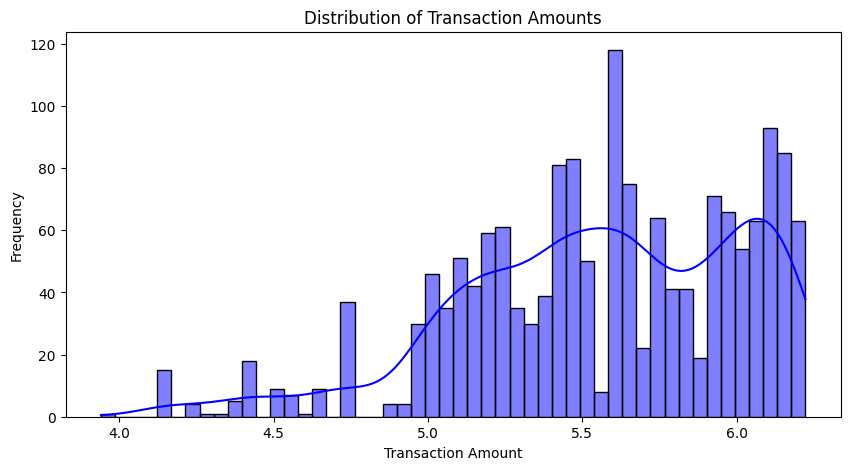

In [68]:
#Shows how transaction values are distributed
if 'TransactionAmount' in final_data.columns:
    plt.figure(figsize=(10,5))
    sns.histplot(final_data['TransactionAmount'].astype(float), bins=50, kde=True, color='blue')
    plt.title('Distribution of Transaction Amounts')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency')
    plt.show()


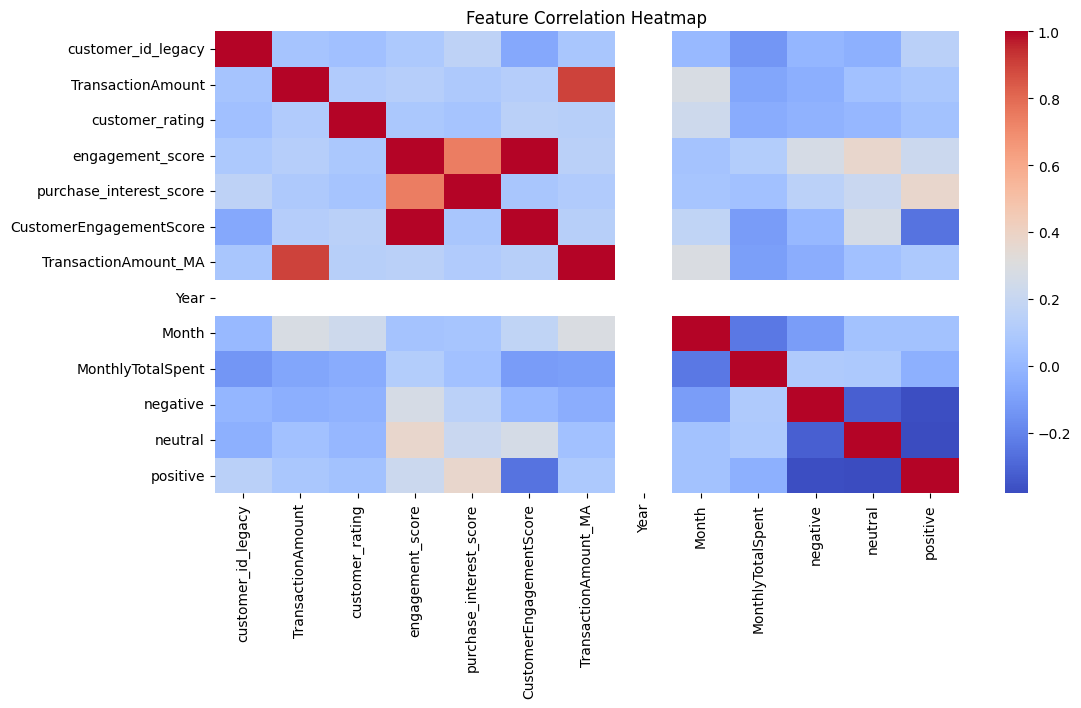

In [69]:
#Plots a heatmap showing feature correlations
numerical_data = final_data.select_dtypes(include=[np.number])
plt.figure(figsize=(12,6))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [70]:
#Defines the target variable (purchase_interest_score)
if 'purchase_interest_score' in final_data.columns:
    y = final_data['purchase_interest_score']
else:
    y = np.random.randint(0, 2, size=len(final_data))  # Placeholder binary target if missing


In [73]:
#Uses ANOVA F-value scoring to rank features
X = numerical_data.drop(columns=['customer_id_legacy'], errors='ignore')

# Impute missing values using SimpleImputer before applying SelectKBest
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median') # or 'mean', depending on your preference
X = imputer.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = numerical_data.drop(columns=['customer_id_legacy'], errors='ignore').columns[selector.get_support()] # Corrected to use original columns
print("Top Selected Features for Machine Learning:")
print(selected_features)

Top Selected Features for Machine Learning:
Index(['TransactionAmount', 'customer_rating', 'engagement_score',
       'CustomerEngagementScore', 'TransactionAmount_MA', 'Month',
       'MonthlyTotalSpent', 'negative', 'neutral', 'positive'],
      dtype='object')


In [74]:
final_data[selected_features].to_csv('/content/final_dataset_ready_5.csv', index=False)
print("Final dataset exported successfully as final_dataset_ready_5.csv")

Final dataset exported successfully as final_dataset_ready_5.csv
